# **Notebook 1**: Data Visualisation

## **Package Installation**

In [120]:
INSTALL_PACKAGES = False

In [ ]:
!pip install -r requirements.txt

## **Dataset Annotation Statistics and Checks**

In this section, checks are performed on the dataset annotations to ensure data integrity and consistency. Specifically, checks are carried out such that:

- Each image has a corresponding annotation.
- Signs are annotated with their expected shape (ex. stop signs are typically octagonal).
- Viewing angle annotations correspond with the file naming convention.

Additionally, various statistics about the dataset are computed and visualised to gain insights into its composition.

In [122]:
group_5_members = ["AlisonAttard", "BenTaliana", "MichaelFarrugia", "MelatAssefa"]

In [123]:
import os

all_images_paths = [os.path.join(member, "images", img) for member in group_5_members for img in os.listdir(os.path.join(member, "images"))]
all_images_json_path = os.path.join("dataset", "merged_input.json")

In [124]:
num_images_per_member = {member: len([img for img in all_images_paths if img.startswith(os.path.join(member, "images"))]) for member in group_5_members}
total_images = len(all_images_paths)

In [125]:
from json import loads

with open(all_images_json_path, "r") as f:
    all_images_json = loads(f.read())

    assert len(all_images_json) == total_images, f"Missing annotations in merged JSON: expected {total_images}, found {len(all_images_json)}"

In [126]:
num_front_images_per_member = {member: len([img for img in all_images_paths if img.startswith(os.path.join(member, "images")) and (img.endswith("_Front.jpg") or img.endswith("_Front.jpeg"))]) for member in group_5_members}
total_front_images = len([img for img in all_images_paths if img.endswith("_Front.jpg") or img.endswith("_Front.jpeg")])

print(f"Number of signs in the dataset: {total_front_images}")

Number of signs in the dataset: 241


Statistics are collected on the dataset on a member-by-member basis.

In [127]:
from collections import defaultdict, Counter

sign_type_statistics = defaultdict(Counter)
viewing_angle_statistics = defaultdict(Counter)
mounting_type_statistics = defaultdict(Counter)
sign_condition_statistics = defaultdict(Counter)
sign_shape_statistics = defaultdict(Counter)

Most signs have an expected sign shape. For our dataset, we expect:
- "Stop" signs to be octagonal
- "No Entry (One Way)" signs to be circular
- "Pedestrian Crossing (Zebra Crossing)" signs to be square
- "Roundabout Ahead" signs to be triangular
- "No Through Road (T-Sign)" signs to be square
- "Blind-Spot Mirrors (Convex Mirrors)" signs to be circular

In [128]:
def expect_sign_shape(sign_type: str, sign_shape: str, img_filename: str):
    expected_shapes = {
        "Stop": "Octagonal",
        "No Entry (One Way)": "Circular",
        "Pedestrian Crossing": "Square",
        "Roundabout Ahead": "Triangular",
        "No Through Road (T-Sign)": "Square",
        "Blind-Spot Mirror (Convex)": "Circular"
    }

    if sign_shape == "Damaged":
        return

    if expected_shapes [sign_type] != sign_shape:
        print(f"{COLOURS ['red']}[!] Sign shape mismatch for '{img_filename}': expected '{expected_shapes [sign_type]} ({sign_type})', found '{sign_shape}'{COLOURS['end']}. Double check to make sure this annotation is accurate")

Checks can now be carried out regarding the sign shape and viewing angle.

In [129]:
for json_entry in all_images_json:
    filename = json_entry ["file_upload"].split("-") [1]

    annotated_items = [
        item
        for annotation in json_entry ["annotations"]
        for item in annotation ["result"]
    ]

    annotated_view_angle = list(filter(lambda item: item.get("from_name") == "view_angle", annotated_items)) [0] ["value"] ["choices"] [0]

    filename_view_angle = filename.replace(".jpeg", ".jpg").split(".jpg") [0].split("_")[-1]

    if annotated_view_angle != filename_view_angle:
        print(f"{COLOURS ['red']}[!] View angle mismatch for '{filename}': expected '{filename_view_angle}', found '{annotated_view_angle}'{COLOURS['end']}. Double check to make sure this annotation is accurate")

    member_name = filename.split("_") [0]

    viewing_angle_statistics [member_name] [annotated_view_angle] += 1
    
    if annotated_view_angle != "Front":
        continue

    annotated_sign_type = list(filter(lambda item: item.get("from_name") == "sign_type", annotated_items)) [0] ["value"] ["rectanglelabels"] [0]

    annotated_mounting_type = list(filter(lambda item: item.get("from_name") == "mounting", annotated_items)) [0] ["value"] ["choices"] [0]

    annotated_sign_condition = list(filter(lambda item: item.get("from_name") == "condition", annotated_items)) [0] ["value"] ["choices"] [0]

    annotated_sign_shape = list(filter(lambda item: item.get("from_name") == "sign_shape", annotated_items)) [0] ["value"] ["choices"] [0]
    
    expect_sign_shape(annotated_sign_type, annotated_sign_shape, filename)

    sign_type_statistics [member_name] [annotated_sign_type] += 1
    mounting_type_statistics [member_name] [annotated_mounting_type] += 1
    sign_condition_statistics [member_name] [annotated_sign_condition] += 1
    sign_shape_statistics [member_name] [annotated_sign_shape] += 1

[!] Sign shape mismatch for 'AlisonAttard_4_Front.jpeg': expected 'Octagonal (Stop)', found 'Circular'. Double check to make sure this annotation is accurate
[!] Sign shape mismatch for 'AlisonAttard_6_Front.jpeg': expected 'Octagonal (Stop)', found 'Circular'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_14_Back.jpeg': expected 'Back', found 'Front'. Double check to make sure this annotation is accurate
[!] Sign shape mismatch for 'AlisonAttard_17_Front.jpeg': expected 'Square (Pedestrian Crossing)', found 'Triangular'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_24_Back.jpeg': expected 'Back', found 'Front'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_34_Back.jpeg': expected 'Back', found 'Front'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_37_Front.jpeg': expected 'Front', found 

The bar charts can now be plotted to visualise the dataset statistics. The function `plot_statistics_stacked_bar` is used to create stacked bar charts for various statistics, re-using this function for different statistics like viewing angle, sign type, mounting type, sign condition, and sign shape.

In [130]:
import matplotlib.colors as mcolors
import colorsys

# used to adjust the lightness of a hex colour
def adjust_lightness(hex_colour, amount = 0.5):
    try:
        c = mcolors.to_rgb(hex_colour)
        h, l, s = colorsys.rgb_to_hls(*c)
        l = max(0, min(1, l * amount))
        
        return mcolors.to_hex(colorsys.hls_to_rgb(h, l, s))
    except:
        return hex_colour

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# used to plot stacked bar charts for dataset statistics
def plot_statistics_stacked_bar(statistics: defaultdict, title: str, xlabel: str, ylabel: str, colour: str):
    # obtaining all possible categories across all members
    categories = set()

    for member_stats in statistics.values():
        categories.update(member_stats.keys())

    categories = sorted(categories)

    plt.figure(figsize = (20, 6))
    bottom = np.zeros(len(categories))

    for i, person in enumerate(statistics.keys()):
        counts = [statistics [person] [category] for category in categories]

        step_darkness = 1 + (i * 0.25)
        colour = adjust_lightness(colour, step_darkness)

        plt.bar(categories, counts, bottom = bottom, label = person, color = colour)

        bottom = np.add(bottom, counts)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize = 16, fontweight = "bold", pad = 30)
    plt.legend(loc = "upper left")
    plt.show()

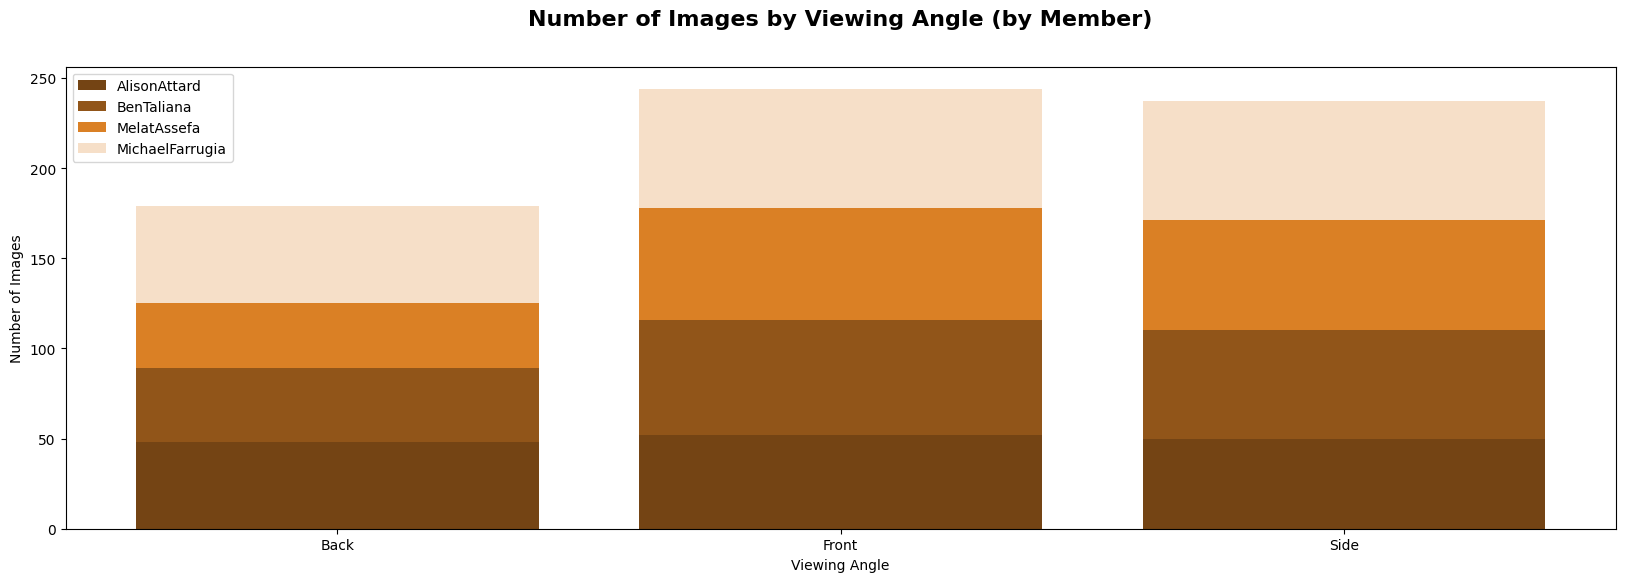

In [132]:
plot_statistics_stacked_bar(
    statistics = viewing_angle_statistics,
    title = "Number of Images by Viewing Angle (by Member)",
    xlabel = "Viewing Angle",
    ylabel = "Number of Images",
    colour = "#744414"
)

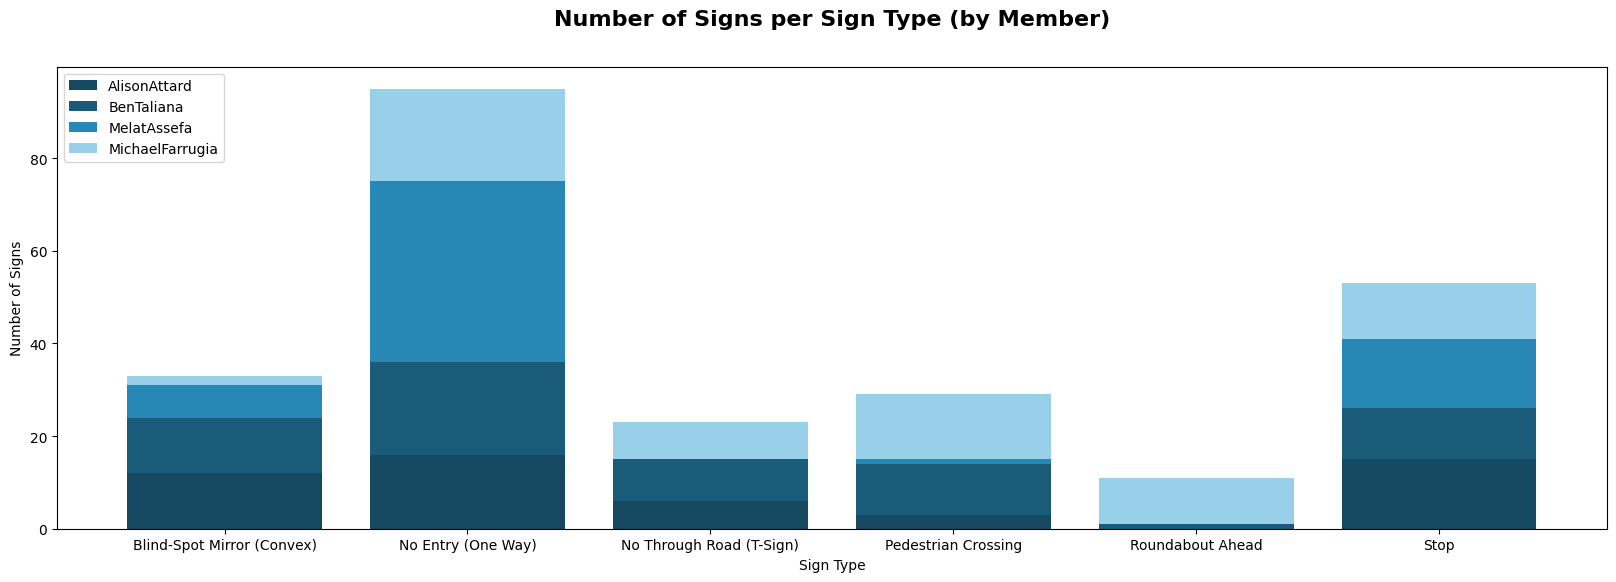

In [133]:
plot_statistics_stacked_bar(
    statistics = sign_type_statistics,
    title = "Number of Signs per Sign Type (by Member)",
    xlabel = "Sign Type",
    ylabel = "Number of Signs",
    colour = "#154961"
)

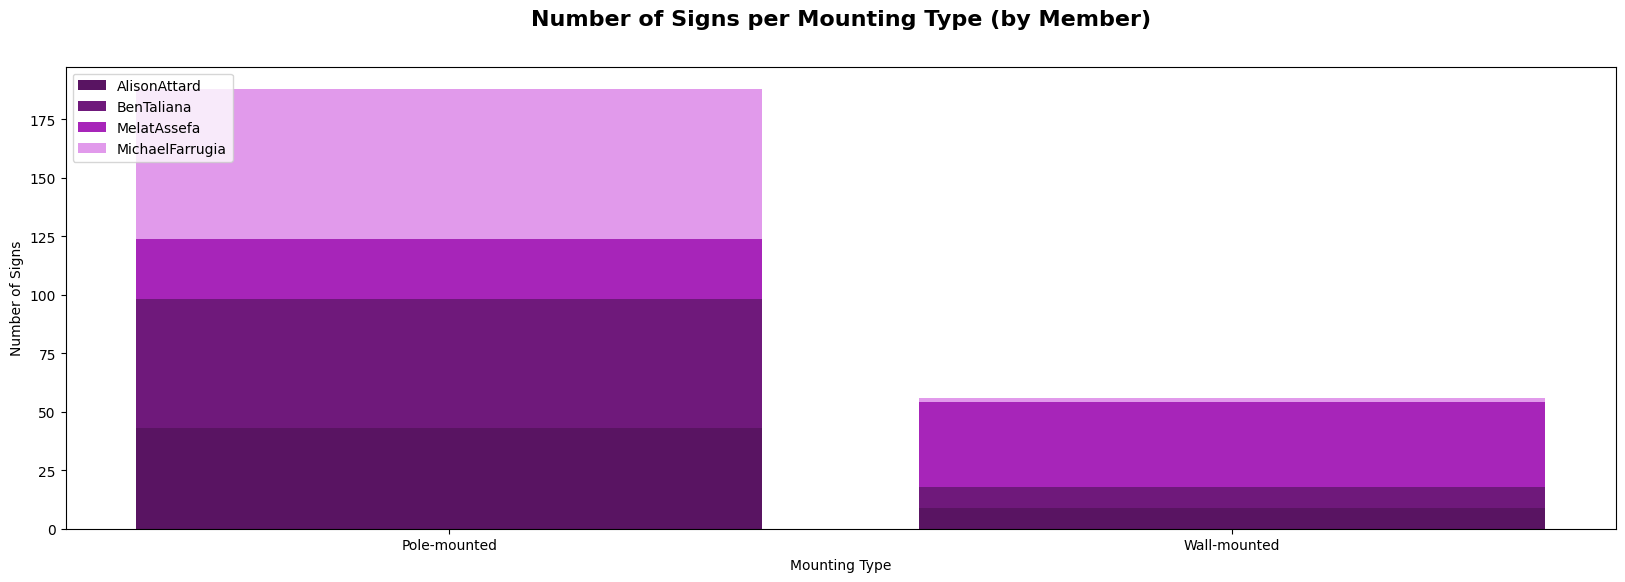

In [134]:
plot_statistics_stacked_bar(
    statistics = mounting_type_statistics,
    title = "Number of Signs per Mounting Type (by Member)",
    xlabel = "Mounting Type",
    ylabel = "Number of Signs",
    colour = "#591462"
)

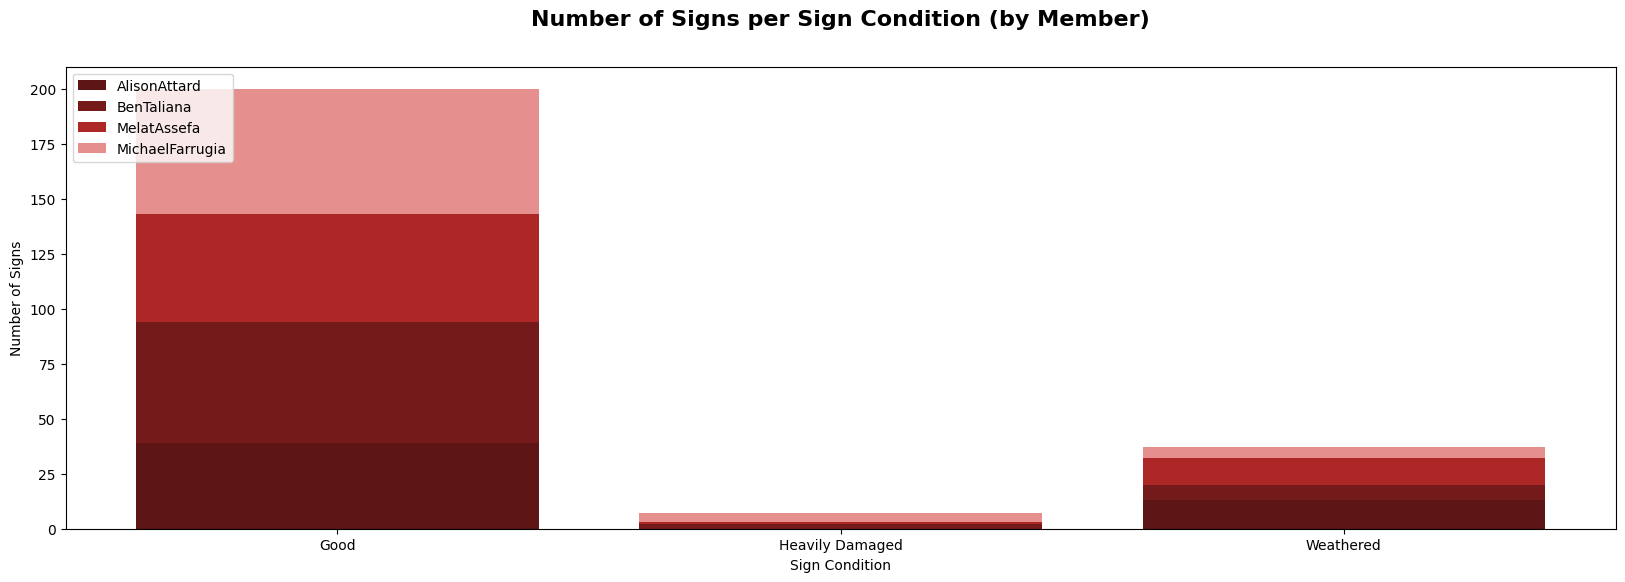

In [135]:
plot_statistics_stacked_bar(
    statistics = sign_condition_statistics,
    title = "Number of Signs per Sign Condition (by Member)",
    xlabel = "Sign Condition",
    ylabel = "Number of Signs",
    colour = "#5D1515"
)

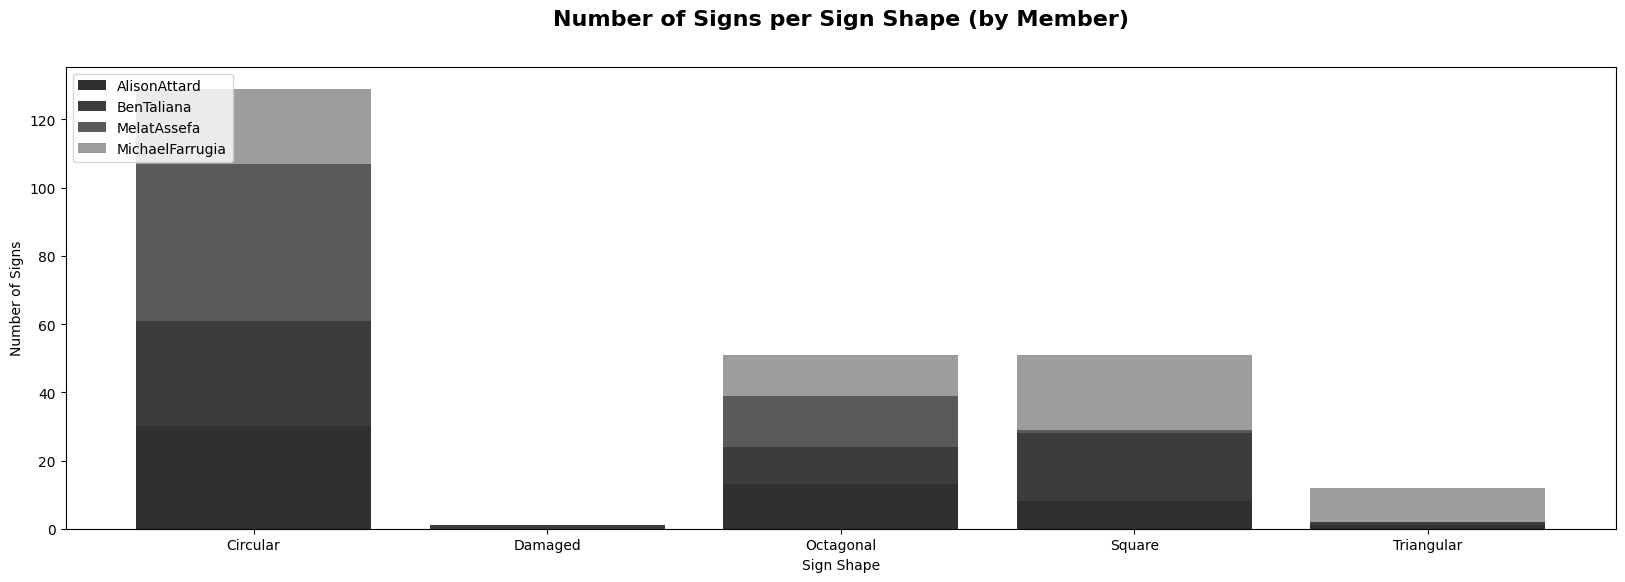

In [136]:
plot_statistics_stacked_bar(
    statistics = sign_shape_statistics,
    title = "Number of Signs per Sign Shape (by Member)",
    xlabel = "Sign Shape",
    ylabel = "Number of Signs",
    colour = "#30302F"
)

## **Dataset Geolocation and Temporal Information Visualisation**

In this section, the geolocation and temporal metadata of the dataset images are visualised using maps. A `folium` map is created to plot the locations where images were captured, along with markers indicating the date and time of capture. This visualisation helps in understanding the spatial and temporal distribution of the dataset.

In [137]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

# used to get GPS EXIF tags from an image
def get_gps_tags(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)

        if tag_name == "GPSInfo":
            gps_data = {}

            for gps_tag in value:
                gps_tag_name = GPSTAGS.get(gps_tag, gps_tag)
                gps_data [gps_tag_name] = value [gps_tag]

            return gps_data

In [138]:
# helper function to show the geolocation information neatly
def convert_dms_to_decimal(dms_coordinate):
    deg, minute, sec = dms_coordinate

    deg = float(deg)
    minute = float(minute) / 60
    sec = float(sec) / 3600
    
    return deg + minute + sec

In [139]:
# used to read an image and get its latitude and longitude coordinates as a tuple
def read_img_and_get_coords(image_path):
    img_gps = get_gps_tags(image_path)
    img_latitude = img_gps ["GPSLatitude"]
    img_longitude = img_gps ["GPSLongitude"]
    
    return (convert_dms_to_decimal(img_latitude), convert_dms_to_decimal(img_longitude))

In [140]:
# reads an image and gets its original date and time from EXIF tags
def get_time_tags(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)

        if tag_name == "DateTimeOriginal":
            return value

In [141]:
from datetime import datetime

# helper function to format date strings
def format_date(date_string):
    dt = datetime.strptime(str(date_string), "%Y:%m:%d %H:%M:%S")
    return dt.strftime("%d/%m/%Y %H:%M")

In [142]:
# used to read an image and get its formatted date and time string
def read_img_and_get_datetime(image_path):
    img_time = get_time_tags(image_path)

    return format_date(img_time)

The map can now be created and displayed with the geolocation and temporal information of the images.

In [143]:
from folium import Map

# the first image's coordinates will be used to center the map
first_img_coords = read_img_and_get_coords(all_images_paths [0])

map = Map(location = first_img_coords, zoom_start = 12)

In [144]:
# different signs will have different coloured markers on the map
SIGN_COLOUR_MAP = {
    "Stop": "red",
    "No Entry (One Way)": "purple",
    "Pedestrian Crossing": "blue",
    "Roundabout Ahead": "green",
    "No Through Road (T-Sign)": "beige",
    "Blind-Spot Mirror (Convex)": "orange"
}

In [145]:
def get_sign_type(img_name: str):
    json_entry = next((entry for entry in all_images_json if entry ["file_upload"].endswith(img_name)), None)

    return json_entry ["annotations"] [0] ["result"] [0] ["value"] ["rectanglelabels"] [0]

In [146]:
from folium import Marker, Icon
from re import sub

for image_path in all_images_paths:
    img_name = image_path.split("images\\") [1].split(".") [0]

    # no need to plot all angles of the same sign, therefore only the front view is considered
    if not img_name.endswith("Front"):
        continue
    
    img_coords = read_img_and_get_coords(image_path)

    sign_number = img_name.split("_Front") [0].split("_") [1]

    member_name = img_name.split("_") [0].split("-") [1]

    try:
        img_datetime = read_img_and_get_datetime(image_path)
    except Exception as e:
        img_datetime = "Unknown"
    
    full_img_name = image_path.split("images\\") [1]
    sign_type = get_sign_type(full_img_name)

    icon_colour = SIGN_COLOUR_MAP.get(sign_type, "gray")

    Marker(
        location = [img_coords [0], img_coords [1]], 
        popup = f"{sub(r'(?<!^)(?=[A-Z])', ' ', member_name)}'s sign {sign_number} taken at {img_datetime} ({sign_type})",
        icon = Icon(color = icon_colour)
    ).add_to(map)

Note that on the map below, not all signs will appear due to the slight misprecision in GPS coordinates - some GPS coordinates did not capture the "seconds" and thus appear to be overlapping on the map. Nonetheless, the geographical distribution of the signs can still be observed.

In [147]:
map

## **Important Aspects of the Dataset**

When collecting the images for the dataset, we discovered a few important aspects about Maltese road signs that are worth noting, as they could impact the performance of any object detection model trained on the dataset:

1. There are **two types of pedestrian crossing signs** used in Malta: the Italian pedestrian crossing sign (with five vertical lines, also used outside of Italy) and the UK pedestrian crossing sign (with two horizontal dashed lines). Both signs are used interchangeably in Malta, which could lead to confusion for an object detection model if it is not trained on both types of signs. Our dataset includes both types of pedestrian crossing signs.

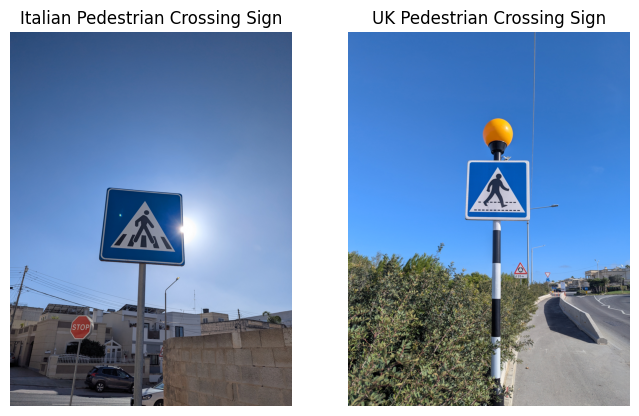

In [148]:
italian_pedestrian_crossing_sign = Image.open(os.path.join("MichaelFarrugia", "images", "e514429b-MichaelFarrugia_64_Front.jpg"))
uk_pedestrian_crossing_sign = Image.open(os.path.join("MichaelFarrugia", "images", "5abaa5dd-MichaelFarrugia_16_Front.jpg"))

plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(italian_pedestrian_crossing_sign)
plt.title("Italian Pedestrian Crossing Sign", fontsize = 12)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uk_pedestrian_crossing_sign)
plt.title("UK Pedestrian Crossing Sign", fontsize = 12)
plt.axis("off")

plt.show()

2. There are **two types of stop signs** used in Malta. One stop sign has a notably larger font size for the word "STOP", and the characters seem slightly taller compared to the other stop sign. Again, both signs are used interchangeably in Malta, so it is important for an object detection model to be trained on both types of stop signs. Our dataset includes both types of stop signs.

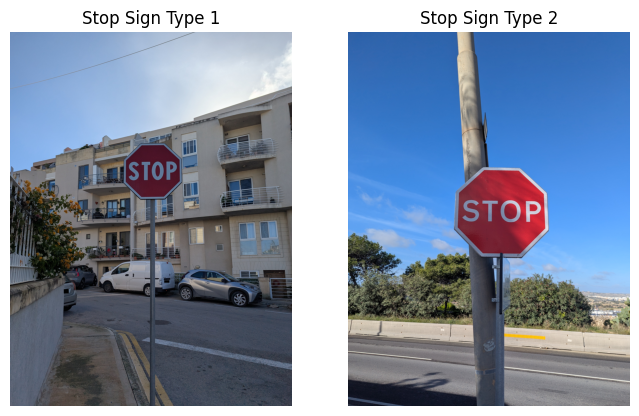

In [149]:
stop_sign_type_1 = Image.open(os.path.join("MichaelFarrugia", "images", "084c5849-MichaelFarrugia_1_Front.jpg"))
stop_sign_type_2 = Image.open(os.path.join("MichaelFarrugia", "images", "613de0fa-MichaelFarrugia_19_Front.jpg"))

plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(stop_sign_type_1)
plt.title("Stop Sign Type 1", fontsize = 12)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(stop_sign_type_2)
plt.title("Stop Sign Type 2", fontsize = 12)
plt.axis("off")

plt.show()

## **Annotation Visualisation Examples**

In this section, some examples of annotated images from the dataset are displayed. These examples showcase the variety of road signs, viewing angles, and conditions present in the dataset. Each image is annotated with bounding boxes and labels indicating the type of sign, which helps in visualising how the annotations look in practice.

In [152]:
from random import sample, seed

seed(1)
sampled_image_paths = sample(all_images_paths, 5)

sampled_json_entries = [
    next((entry for entry in all_images_json if entry ["file_upload"].endswith(image_path.split("images\\") [1])), None)
    for image_path in sampled_image_paths
]

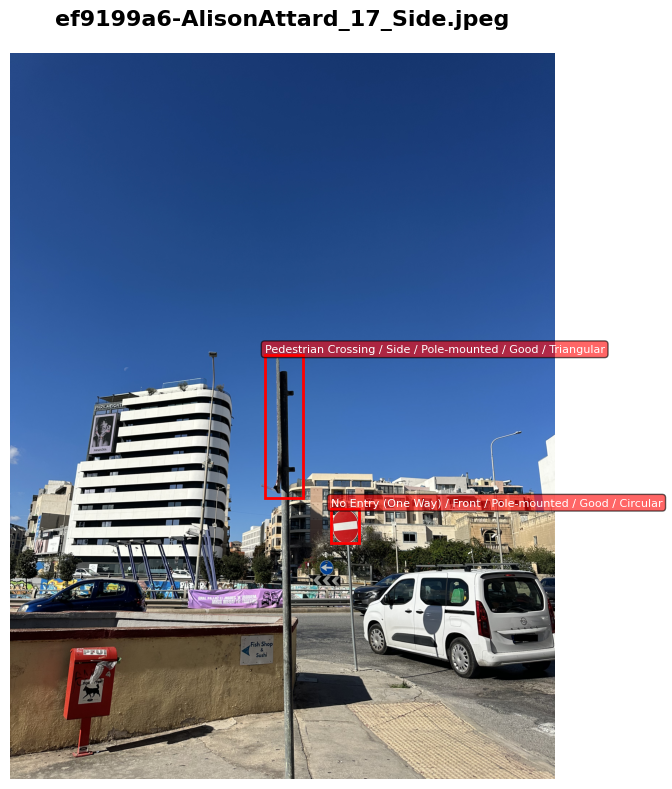

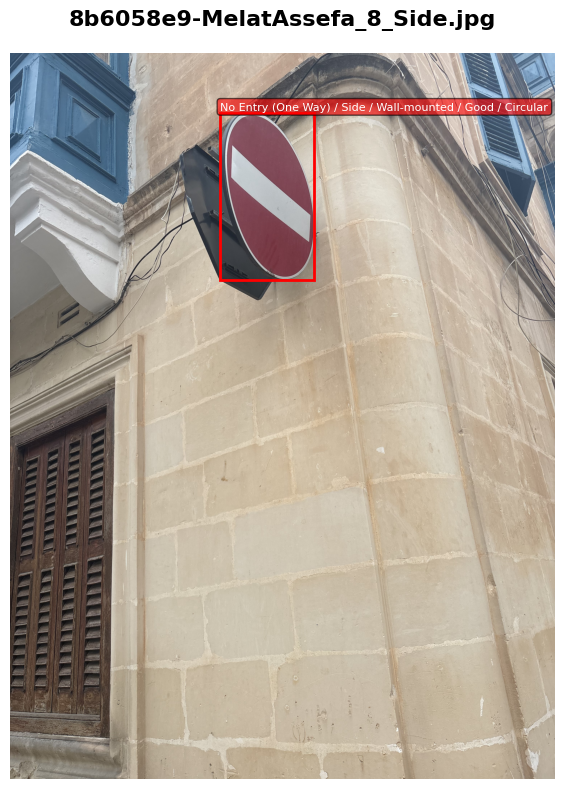

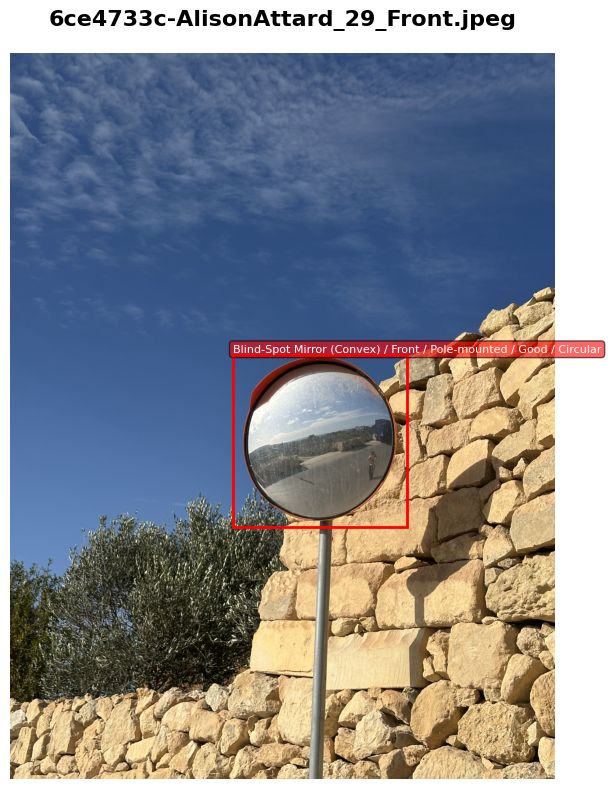

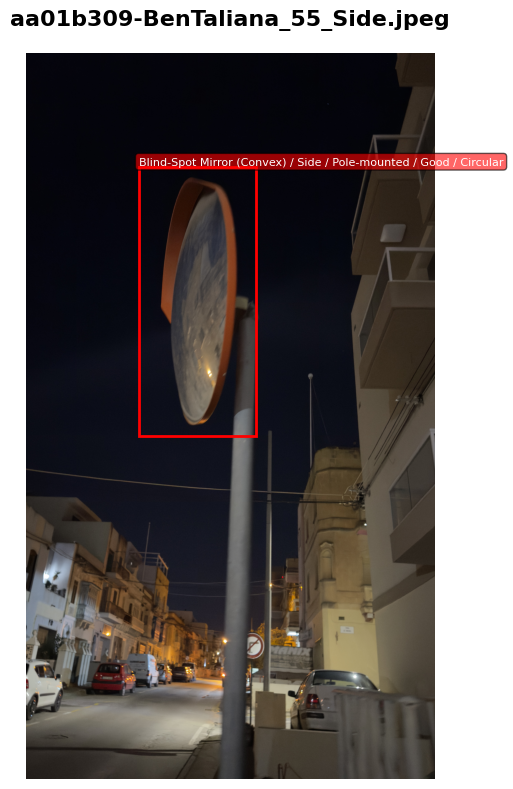

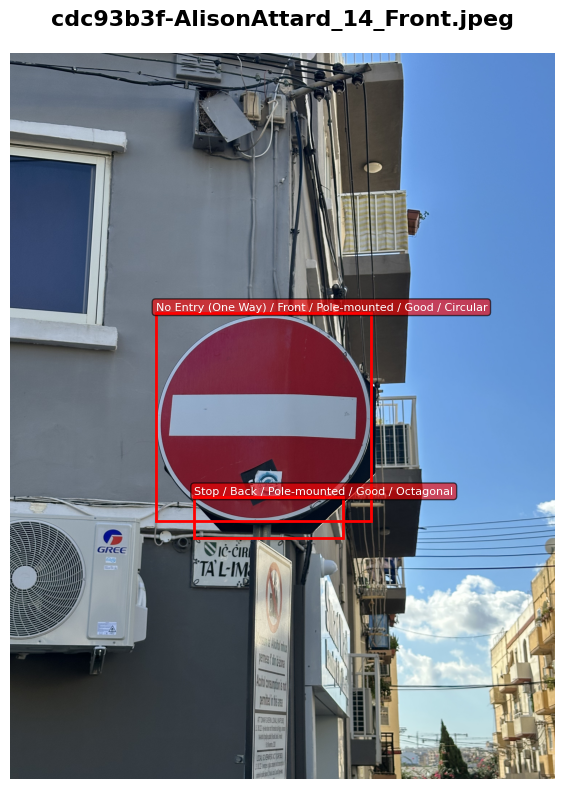

In [164]:
import matplotlib.patches as patches
from collections import defaultdict
from PIL import ImageOps

for image_path, json_entry in zip(sampled_image_paths, sampled_json_entries):
    image = Image.open(image_path)
    
    # fix image orientation based on EXIF data
    image = ImageOps.exif_transpose(image)
    
    image_filename = image_path.split("images\\") [1]

    fig, ax = plt.subplots(1, figsize = (12, 8))
    ax.imshow(image)

    # grouping annotations by their ID (same bounding box, different properties)
    annotations_by_id = defaultdict(dict)
    
    for annotation in json_entry ["annotations"]:
        for item in annotation ["result"]:
            item_id = item.get("id")
            from_name = item.get("from_name")
            
            if item_id not in annotations_by_id:
                annotations_by_id [item_id] = {
                    "bbox": None,
                    "original_width": item.get("original_width"),
                    "original_height": item.get("original_height"),
                    "properties": {}
                }
            
            # store the bounding box coordinates (same for all properties with same ID)
            if "value" in item and "x" in item ["value"]:
                annotations_by_id [item_id] ["bbox"] = item ["value"]
            
            # store the property value
            if from_name == "sign_type" and "rectanglelabels" in item ["value"]:
                annotations_by_id [item_id] ["properties"] ["sign_type"] = item ["value"] ["rectanglelabels"] [0]
            elif from_name in ["view_angle", "mounting", "condition", "sign_shape"] and "choices" in item ["value"]:
                annotations_by_id [item_id] ["properties"] [from_name] = item ["value"] ["choices"] [0]
    
    # draw rectangles and labels for each annotation
    for item_id, ann_data in annotations_by_id.items():
        bbox = ann_data ["bbox"]
        properties = ann_data ["properties"]
        
        if bbox is None:
            continue
        
        # convert percentage coordinates to pixel coordinates
        img_width, img_height = image.size
        x = (bbox ["x"] / 100) * img_width
        y = (bbox ["y"] / 100) * img_height
        width = (bbox ["width"] / 100) * img_width
        height = (bbox ["height"] / 100) * img_height
        
        rect = patches.Rectangle(
            (x, y), width, height,
            linewidth = 2,
            edgecolor = "red",
            facecolor = "none"
        )
        ax.add_patch(rect)
        
        label_parts = []

        if "sign_type" in properties:
            label_parts.append(properties ["sign_type"])
        if "view_angle" in properties:
            label_parts.append(properties ["view_angle"])
        if "mounting" in properties:
            label_parts.append(properties ["mounting"])
        if "condition" in properties:
            label_parts.append(properties ["condition"])
        if "sign_shape" in properties:
            label_parts.append(properties ["sign_shape"])
        
        label_text = " / ".join(label_parts)
        
        ax.text(
            x, y - 5,
            label_text,
            fontsize = 8,
            color = "white",
            backgroundcolor = "red",
            bbox = dict(boxstyle = "round,pad=0.3", facecolor = "red", alpha = 0.6),
            verticalalignment = "bottom"
        )
    
    ax.set_title(f"{image_filename}", fontsize = 16, fontweight = "bold", pad = 20)
    ax.axis("off")
    plt.tight_layout()
    plt.show()